In [1]:
import matplotlib
%matplotlib inline
## from phylonetwork import PhyloNetwork
import networkx as nx
import phylonetwork
import pylab as plt
import random,numpy
import itertools
from networkx.drawing.nx_agraph import graphviz_layout

In [2]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

In [3]:
def last_node(net):
    return max(net.nodes())

In [4]:
def speciate(net,leaf):
    l = last_node(net)
    net.add_edge(leaf,l+1)
    net.add_edge(leaf,l+2)

In [5]:
def lgt(net,leaf1,leaf2):
    net.add_edge(leaf1,leaf2,secondary=True)
    l = last_node(net)
    net.add_edge(leaf1,l+1)
    net.add_edge(leaf2,l+2)

In [6]:
def draw(net):
    positions = nx.drawing.nx_agraph.graphviz_layout(net, prog="dot")
    # nx.draw(net, pos=graphviz_layout(net),prog='dot',args="-Grankdir=LR", with_labels=True)
    nx.draw(net,positions,with_labels=True)
    plt.show()

In [7]:
def leaves(net):
    return [u for u in net.nodes() if net.out_degree(u)==0]

In [8]:
def non_trivial_blobs(net):
    blobs = list(nx.biconnected_components(nx.Graph(net)))
    return [bl for bl in blobs if len(bl) > 2]

In [9]:
def internal_blobs(net):
    internal_nodes = set([u for u in net.nodes() if net.out_degree(u)>0])
    blobs = list(nx.biconnected_components(nx.Graph(net)))
    blobs = [bl for bl in blobs if len(bl) > 2]
    nodes_in_blobs = set().union(*blobs)
    nodes_not_in_blobs = internal_nodes - nodes_in_blobs
    blobs.extend([set([u]) for u in nodes_not_in_blobs])
    return blobs

In [10]:
def compute_hash(net):
    mapping_blobs = {}
    blobs = internal_blobs(net)
    for blob in blobs:
        for node in blob:
            mapping_blobs[node] = blob
    
    mapping = {}
    for l in leaves(net):
        parent = net.predecessors(l)[0]
        mapping[l] = mapping_blobs[parent]
    return mapping

In [11]:
def internal_and_external_pairs(net):
    lvs = leaves(net)
    pairs = [(l1,l2) for l1 in lvs for l2 in lvs if l1 != l2]
    mapping = compute_hash(net)
    internal_pairs = []
    external_pairs = []
    for pair in pairs:
        if mapping[pair[0]] == mapping[pair[1]]:
            internal_pairs.append(pair)
        else:
            external_pairs.append(pair)
    return internal_pairs, external_pairs

In [12]:
def random_leaf(net):
    return random.choice(leaves(net))

In [13]:
def random_pair(net,wint,wext):
    int_pairs, ext_pairs = internal_and_external_pairs(net)
    return random.choices(int_pairs+ext_pairs, weights=[wint]*len(int_pairs)+[wext]*len(ext_pairs))[0]

In [14]:
def simulation(num_steps,prob_lgt,wint,wext):
    net = nx.DiGraph()
    net.add_edge(1,2)
    net.add_edge(1,3)
    for i in range(num_steps):
        event = random.choices(['spec','lgt'],[1-prob_lgt, prob_lgt])[0]
        #event = numpy.random.choice(['spec','lgt'],p=[1-prob_lgt, prob_lgt])
        if event == 'spec':
            l = random.choice(leaves(net))
            speciate(net,l)
        else:
            pair = random_pair(net,wint,wext)
            lgt(net,pair[0],pair[1])
    return net

In [15]:
def reticulations(G):
    return [v for v in G.nodes() if G.in_degree(v)==2]
def local_level(G,bicc):
    rets=list(set(reticulations(G)).intersection(bicc)) # reticulations present in the blob
    if len(rets)==0:
        return 0
    else:
        bicc_edges=[e for e in G.edges() if ((e[0] in bicc)&(e[1]in bicc))]
        end_nodes=[e[1] for e in bicc_edges]
        return len([ret for ret in rets if ret in end_nodes]) 

In [16]:
number_of_experiments = 500
values_of_n = [30,50]
values_of_alpha = [0.1, 0.3]
values_of_beta = [0.01,0.02,0.05,0.1,0.2,1,5,10,20,50,100]
stats_level = {}
stats_numblobs = {}

for (n, alpha, beta) in itertools.product(values_of_n, values_of_alpha, values_of_beta):
    levels = []
    numblobs = []
    for _ in range(number_of_experiments):
        resG = simulation(n, alpha, 1, beta)
        bic_comp=list(nx.biconnected_components(nx.Graph(resG)))
        rets_x_bicc=[local_level(resG,b) for b in bic_comp]
        level=max(rets_x_bicc)
        levels.append(level)
        sparse=[1 for x in rets_x_bicc if x!=0]
        numblobs.append(sum(sparse))
    stats_level[(n, alpha, beta)] = float(sum(levels))/len(levels)
    stats_numblobs[(n, alpha, beta)] = float(sum(numblobs))/len(numblobs)

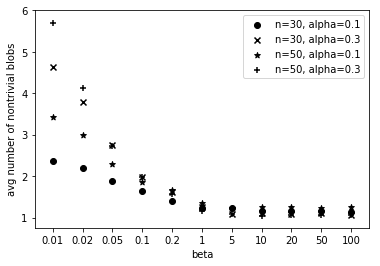

In [29]:
f = plt.figure()
x_positions=range(len(values_of_beta))
x_axis = values_of_beta
symbols = "ox*+"
i = 0
dibs = [None]*4
legends = [None]*4
for n in values_of_n:
    for alpha in values_of_alpha:
        to_plot = [stats_numblobs[(n, alpha, beta)] for beta in values_of_beta]
        dibs[i]=plt.scatter(x_positions, to_plot, marker = symbols[i], c='black')
        legends[i] = "n=%d, alpha=%0.1f" % (n, alpha)
        i += 1
plt.xticks(x_positions, x_axis)
plt.legend(dibs, legends)
plt.xlabel('beta')
plt.ylabel('avg number of nontrivial blobs')
plt.show()
f.savefig("fig10.pdf", bbox_inches='tight')

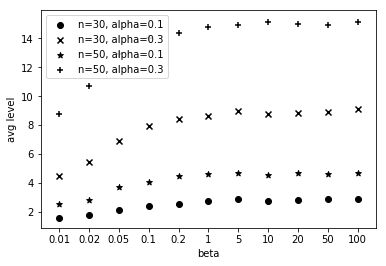

In [30]:
f = plt.figure()
x_positions=range(len(values_of_beta))
x_axis = values_of_beta
symbols = "ox*+"
i = 0
dibs = [None]*4
legends = [None]*4
for n in values_of_n:
    for alpha in values_of_alpha:
        to_plot = [stats_level[(n, alpha, beta)] for beta in values_of_beta]
        dibs[i]=plt.scatter(x_positions, to_plot, marker = symbols[i], c='black')
        legends[i] = "n=%d, alpha=%0.1f" % (n, alpha)
        i += 1
plt.xticks(x_positions, x_axis)
plt.legend(dibs, legends)
plt.xlabel('beta')
plt.ylabel('avg level')
plt.show()
f.savefig("fig11.pdf", bbox_inches='tight')

In [19]:
number_of_experiments2 = 500
values_of_n2 = [10,20,30]
values_of_alpha2 = [0,0.1,0.2,0.3,0.4]
values_of_beta2 = [0.01, 1, 10]
stats_level2 = {}
stats_numblobs2 = {}

for (n, alpha, beta) in itertools.product(values_of_n2, values_of_alpha2, values_of_beta2):
    levels = []
    numblobs = []
    for _ in range(number_of_experiments):
        resG = simulation(n, alpha, 1, beta)
        bic_comp=list(nx.biconnected_components(nx.Graph(resG)))
        rets_x_bicc=[local_level(resG,b) for b in bic_comp]
        level=max(rets_x_bicc)
        levels.append(level)
        sparse=[1 for x in rets_x_bicc if x!=0]
        numblobs.append(sum(sparse))
    stats_level2[(n, alpha, beta)] = float(sum(levels))/len(levels)
    stats_numblobs2[(n, alpha, beta)] = float(sum(numblobs))/len(numblobs)

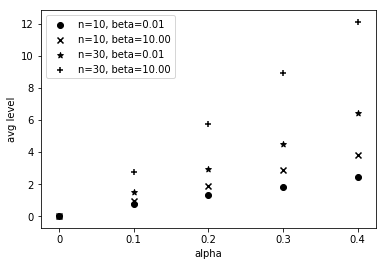

In [31]:
f = plt.figure()
x_positions=range(len(values_of_alpha2))
x_axis = values_of_alpha2
symbols = "ox*+"
i = 0
dibs = [None]*4
legends = [None]*4
for n in [10,30]:
    for beta in [0.01,10]:
        to_plot = [stats_level2[(n, alpha, beta)] for alpha in values_of_alpha2]
        dibs[i]=plt.scatter(x_positions, to_plot, marker = symbols[i], c='black')
        legends[i] = "n=%d, beta=%0.2f" % (n, beta)
        i += 1
plt.xticks(x_positions, x_axis)
plt.legend(dibs, legends)
plt.xlabel('alpha')
plt.ylabel('avg level')
plt.show()
f.savefig("fig8.pdf", bbox_inches='tight')

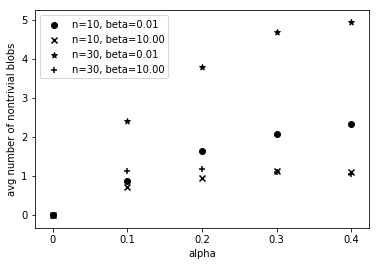

In [32]:
f = plt.figure()
x_positions=range(len(values_of_alpha2))
x_axis = values_of_alpha2
symbols = "ox*+"
i = 0
dibs = [None]*4
legends = [None]*4
for n in [10,30]:
    for beta in [0.01,10]:
        to_plot = [stats_numblobs2[(n, alpha, beta)] for alpha in values_of_alpha2]
        dibs[i]=plt.scatter(x_positions, to_plot, marker = symbols[i], c='black')
        legends[i] = "n=%d, beta=%0.2f" % (n, beta)
        i += 1
plt.xticks(x_positions, x_axis)
plt.legend(dibs, legends)
plt.xlabel('alpha')
plt.ylabel('avg number of nontrivial blobs')
plt.show()
f.savefig("fig9.pdf", bbox_inches='tight')